# Cover It !

In [1]:
import numpy as np
# import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.rcParams['figure.figsize'] = (16,9)

import argparse
import os
import math
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, utils
from torchvision.utils import save_image

from skimage import io
from PIL import Image, ImageOps

**Configs**

In [2]:
PROJECT_DIR = '/home/kazim/Desktop/project/cover_it'
IMAGE_SIZE = (256,256)
BATCH_SIZE = 16

# Data Preperation

In [3]:
os.listdir(f'{PROJECT_DIR}/data/raw/coco-test2017')[0]

'000000097198.jpg'

In [4]:
class CoverItDataset(Dataset):
    """Cover It dataset."""

    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.indexdict = {idx:image for idx,image in enumerate(os.listdir(self.root_dir))}

    def __len__(self):
        return len(os.listdir(self.root_dir))

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = os.path.join(self.root_dir,
                                    str(self.indexdict[idx]))
    
        image = io.imread(img_path)
        
        if image.shape[-1] != 3: #black white photo
#             print(f"image:{img_path} || must have 3 color channels!")
#             print(image.shape)
            image = np.repeat(image[:, :, np.newaxis], 3, axis=2)
#             print(image.shape)
        sample = image

        if self.transform:
            sample = self.transform(sample)

        return sample

In [5]:
## DEBUG

# img_path = "/home/kazim/Desktop/project/cover_it/data/raw/coco-test2017/000000059177.jpg"
# # img_path = "/home/kazim/Desktop/project/cover_it/data/raw/coco-test2017/000000000001.jpg"

# image = io.imread(img_path)
# print(image.shape)
# h,w = image.shape
# image = np.repeat(image[:, :, np.newaxis], 3, axis=2)
# # image = (image * np.ones((1,1,1), dtype=np.int8)).t
# print(image.shape)


In [6]:
# h,w = image.shape
# image = (image * np.ones((1,1,1), dtype=np.int8)).transpose(1,2,0)

# plt.imshow(image.squeeze() ,cmap=plt.get_cmap('gray'))

## Raw Dataset

In [7]:
coverit_dataset = CoverItDataset(root_dir=f'{PROJECT_DIR}/data/raw/coco-test2017')

length of dataset: 40670
0 (480, 640, 3)
1 (483, 640, 3)
2 (428, 640, 3)
3 (640, 457, 3)
4 (640, 427, 3)
5 (500, 375, 3)
6 (480, 640, 3)
7 (480, 640, 3)
8 (427, 640, 3)
9 (500, 334, 3)
10 (425, 640, 3)
11 (480, 640, 3)
12 (424, 640, 3)
13 (430, 640, 3)
14 (480, 640, 3)
15 (449, 640, 3)


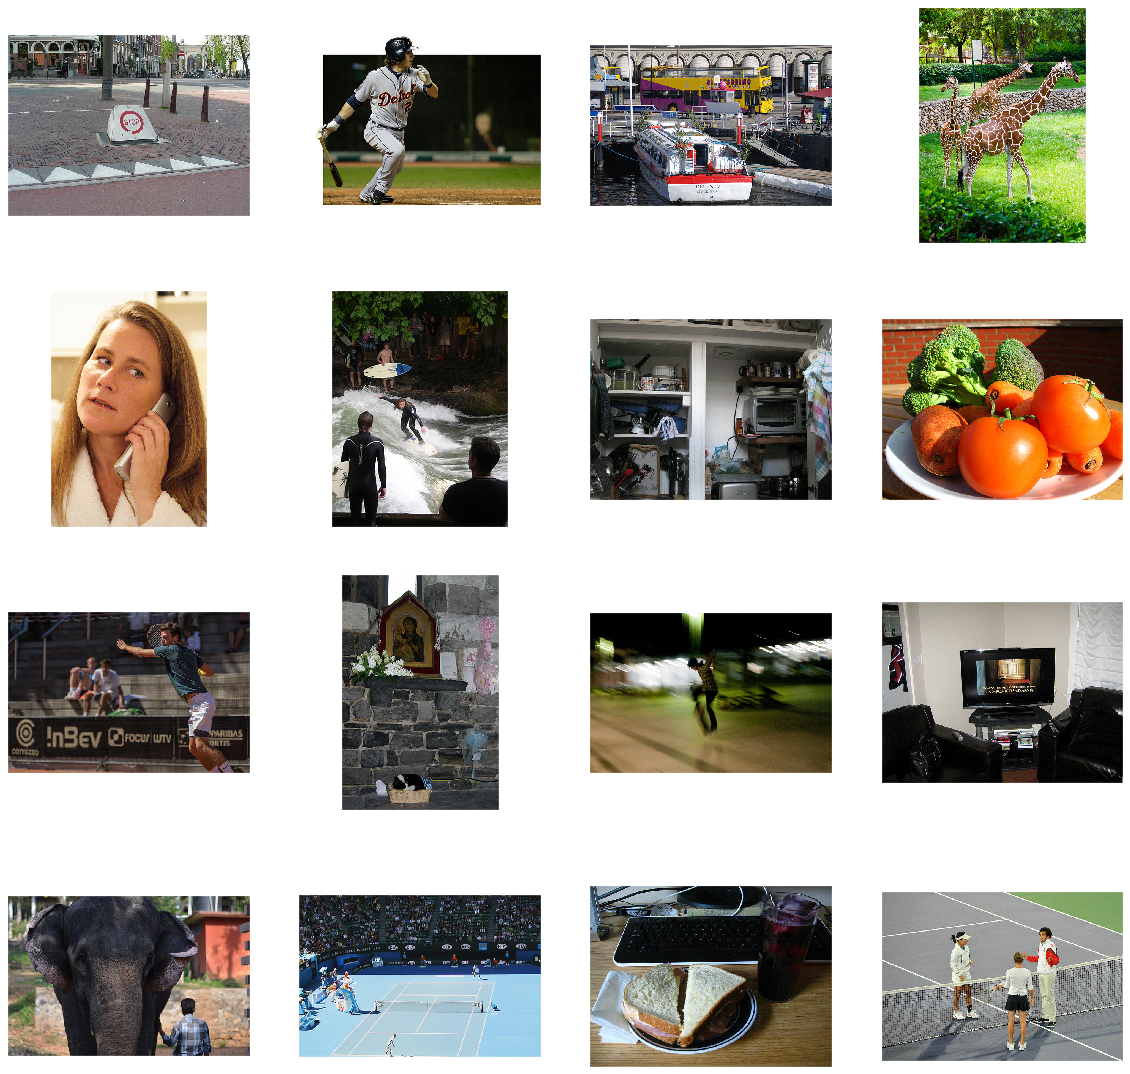

In [8]:
print('length of dataset:',len(coverit_dataset))

fig,axis = plt.subplots(4,4, figsize=(20,20))
axis = axis.reshape(-1)
for i,ax in enumerate(axis):
    sample = coverit_dataset[i]
    print(i, sample.shape)
    ax.imshow(sample)
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])

## Transformations

In [9]:
class PadCenterCrop(object):
    """
    Get the center/random crop of an image with given size. If image is too small pad it accordingly.
    """

    def __init__(self, out_size, is_random_crop=False):
        if isinstance(out_size, int):
            self.out_size = (out_size, out_size)
        elif isinstance(out_size, tuple):
            self.out_size = out_size
        else:
            raise Exception('Expect int or tuple only!')
        
        self.random_crop = is_random_crop

    def __call__(self, img):
                           
        w, h = img.size
        th, tw = self.out_size
        
        diff = min(img.size) - max(self.out_size)
        
        if diff < 0:
            img = ImageOps.expand(img, border=-diff, fill=0)
            w, h = img.size
            

        if w == tw and h == th:
            return img
        
        if self.random_crop:
            x1 = random.randint(0, w - tw)
            y1 = random.randint(0, h - th)
        else:
            x1 = (w - tw)/2 
            y1 = (h - th)/2 
        return img.crop((x1, y1, x1 + tw, y1 + th))

In [10]:
class ToTensor(object):
    """Converts a PIL.Image or numpy.ndarray (H x W x C) in the range
    [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0].
    """
    def __init__(self,is_gray = False, do_normalize = True):
        self.is_gray = is_gray
        
        
    def __call__(self, pic):
        if isinstance(pic, np.ndarray):
            # handle numpy array
            img = torch.from_numpy(pic.transpose((2, 0, 1)))
            # backard compability
            return img.float().div(255)
        # handle PIL Image
        if pic.mode == 'I':
            img = torch.from_numpy(np.array(pic, np.int32, copy=False))
        elif pic.mode == 'I;16':
            img = torch.from_numpy(np.array(pic, np.int16, copy=False))
        else:
            img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))
        # PIL image mode: 1, L, P, I, F, RGB, YCbCr, RGBA, CMYK
        if pic.mode == 'YCbCr':
            nchannel = 3
        elif pic.mode == 'I;16':
            nchannel = 1
        else:
            nchannel = len(pic.mode)
        img = img.view(pic.size[1], pic.size[0], nchannel)
        
        if self.is_gray:
            coef = torch.tensor([0.299,0.587,0.114])
            img = (img * coef.view(1,1,-1)).sum(axis=-1,keepdims=True)
        
        img = img.transpose(0, 1).transpose(0, 2).contiguous()
        if isinstance(img, torch.ByteTensor):
            return img.float().div(255)
        else:
            return img.div(255)

In [11]:
# toPIL = transforms.ToPILImage()
# # scale = Rescale((250,250))
# crop = PadCenterCrop((100,100))

In [12]:
# fig,axis = plt.subplots(4,4, figsize=(20,20))
# axis = axis.reshape(-1)
# for i,ax in enumerate(axis):
#     sample = crop(toPIL(coverit_dataset[i]))
#     print(i, sample.size)
#     ax.imshow(sample)
#     ax.grid(False)
#     ax.set_xticks([])
#     ax.set_yticks([])

In [13]:
# from inspect import getsource
# print(getsource(transforms.ToTensor))

## Transformed Dataset

In [14]:
coverit_dataset_transformed = CoverItDataset(root_dir=f'{PROJECT_DIR}/data/raw/coco-test2017',
                                             transform=transforms.Compose([
                                                 transforms.ToPILImage(),
                                                 PadCenterCrop(out_size=IMAGE_SIZE),
                                                 ToTensor(is_gray=False)
                                             ]))

In [15]:
print('length of dataset:',len(coverit_dataset_transformed))

length of dataset: 40670


In [16]:
def show_image(image, fig_size = None, log_dims=False, is_return=False):
    """
    Args:
        image: tensor
    """
    if len(image.shape) == 2:
        image = image[None,:,:]
        
    is_colored = not (image.shape[0] == 1)
    if is_colored:
        image_np = image.numpy().transpose(1,2,0)
    else:
        image_np = image.numpy()

    if log_dims:
        print(i, image_np.shape)

    if is_colored:
        plt.imshow(image_np)
    else:
        plt.imshow(image_np[0] ,cmap=plt.get_cmap('gray'))
    
    ax,fig = plt.gca(), plt.gcf()
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    if fig_size:fig.set_size_inches(fig_size)
    
    if is_return:
        return fig

In [17]:
image = coverit_dataset_transformed[0]
image.shape

torch.Size([3, 256, 256])

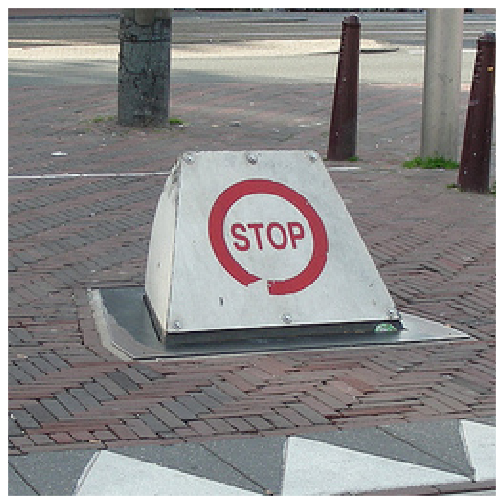

In [18]:
show_image(image, is_return=False)


## Data Loader

In [19]:
dataloader = DataLoader(coverit_dataset_transformed, batch_size = BATCH_SIZE, num_workers=1, shuffle=False)

In [20]:
batch = next(iter(dataloader))

In [21]:
batch.shape

torch.Size([16, 3, 256, 256])

In [22]:
def show_batch(batch, figsize=(10,10), log_dims=False, is_return=False):
    """
    Args:
        batch: tensor
    """
    subplot_size = int(batch.shape[0]**(1/2))
    is_colored = not (batch.shape[1] == 1)

    batch_np = batch.numpy().transpose(0, 2, 3, 1)

    fig, axis = plt.subplots(subplot_size, subplot_size, figsize=figsize)
    axis = axis.reshape(-1)
    for i, ax in enumerate(axis):
        sample = batch_np[i]
        if log_dims:
            print(i, sample.shape)

        if is_colored:
            ax.imshow(sample)
        else:
            ax.imshow(sample.squeeze(), cmap=plt.get_cmap('gray'))

        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])

    if is_return:
        return fig

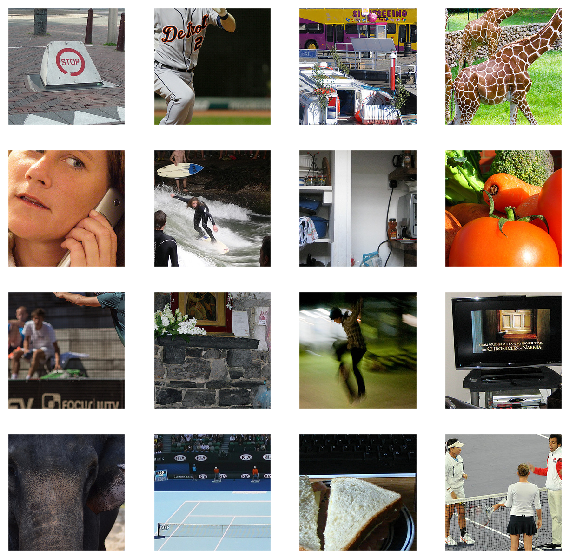

In [23]:
show_batch(batch)

# Model

In [24]:
def calc_cnn(
        input_size=128,
        padding=1,
        kernel_size=3,
        stride=1):
    output_size = (input_size+2*padding-kernel_size)//stride + 1
    return output_size

calc_cnn()

128

In [25]:
class Encoder(nn.Module):
    def __init__(self, nc=1, nhf=8, output_function=nn.Sigmoid):
        super(Encoder, self).__init__()
        # input is (3) x 256 x 256 if colored
        # input is (1) x 256 x 256 if not colored

        self.main = nn.Sequential( #16 1 256 256
            nn.Conv2d(nc, nhf, 3, 1, 1),#16 8 256 256
            nn.BatchNorm2d(nhf),
            nn.ReLU(True), #16 8 256 256
            nn.MaxPool2d(2), #16 8 128 128
            nn.Conv2d(nhf, nhf*2, 3, 1, 1), #16 16 128 128
            nn.BatchNorm2d(nhf*2),
            nn.ReLU(True), 
            nn.MaxPool2d(2), #16 16 64 64
            nn.Conv2d(nhf*2, nhf*4, 3, 1, 1),  #16 32 64 64
            nn.BatchNorm2d(nhf*4),
            nn.ReLU(True), 
            nn.MaxPool2d(2), #16 32 32 32
            output_function()
        )

    def forward(self, input):
        output=self.main(input)
        return output

In [26]:
Encoder(nc=3)(batch).shape

torch.Size([16, 32, 32, 32])

**Look at transformerdecoder!!!**

In [27]:
class Decoder(nn.Module):
    def __init__(self, nc=1, nhf=8, output_function=nn.Sigmoid):
        super(Decoder, self).__init__()
        # input is (32) x 32 x 32 
        
        self.main = nn.Sequential( #16 32 32 32
            nn.UpsamplingBilinear2d(scale_factor=2), #16 32 64 64
            nn.ReLU(True),
            nn.BatchNorm2d(nhf*4),
            nn.Conv2d(nhf*4, nhf*2, 3, 1, 1), #16 16 64 64
            nn.UpsamplingBilinear2d(scale_factor=2), #16 16 128 128
            nn.ReLU(True),
            nn.BatchNorm2d(nhf*2),
            nn.Conv2d(nhf*2, nhf, 3, 1, 1), #16 8 128 128
            nn.UpsamplingBilinear2d(scale_factor=2), #16 8 256 256
            nn.ReLU(True),
            nn.BatchNorm2d(nhf),
            nn.Conv2d(nhf, nc, 3, 1, 1), #16 1 256 256
            output_function()
        )

    def forward(self, input):
        output=self.main(input)
        return output

In [28]:
Decoder(nc=3)(torch.rand((16,32,32,32))).shape

torch.Size([16, 3, 256, 256])

In [29]:
class AutoEncoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(AutoEncoder,self).__init__()
        self.encoder = encoder
        self.decoder = decoder
    def forward(self,x):
        z = self.encoder(x)
        x = self.decoder(z)
        return x

In [30]:
encoder = Encoder(nc=3).cuda()
decoder = Decoder(nc=3).cuda()
autoencoder = AutoEncoder(encoder,decoder).cuda()

## Results Before Traning

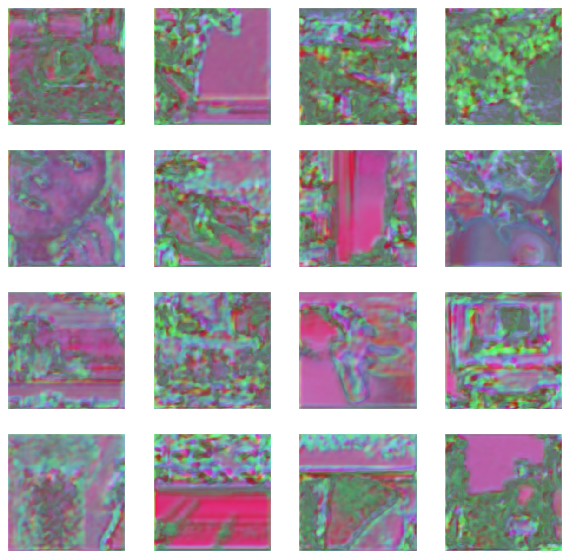

In [31]:
generated = autoencoder(batch.cuda()).detach().cpu()

show_batch(generated,figsize=(10,10))

In [32]:
# removing early experiments
# !rm -rf logs

In [33]:
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
# Sets up a timestamped log directory.
logdir = "logs/train_data/" + datetime.now().strftime("%Y%m%d-%H%M")
print(logdir)
# Creates a file writer for the log directory.
writer = SummaryWriter(logdir)

logs/train_data/20200415-0056


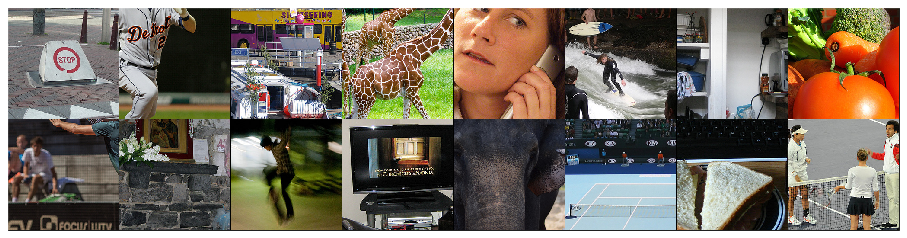

In [34]:
# get some random training images
# dataiter = iter(dataloader)
# images = dataiter.next()

# create grid of images
img_grid = torchvision.utils.make_grid(batch)

# show images
show_image(img_grid)

# write to tensorboard
writer.add_image('batch_cover_it_images', img_grid, dataformats='CHW' )

In [35]:
# writer.add_graph(autoencoder, batch.cuda())
# writer.close()

In [36]:
# !tensorboard --logdir=runs/cover_it_experiment_1

## Load Model

In [37]:
model_id = logdir.split('/')[-1]
print(model_id)
model_dir = f"./models/{model_id}"
print(model_dir)


20200415-0056
./models/20200415-0056


In [38]:
#Create Dirs if doesn't exist

os.makedirs(f"./generated_images/{model_id}", exist_ok=True)
os.makedirs(f'./models/{model_id}/encoder',exist_ok=True)
os.makedirs(f'./models/{model_id}/decoder',exist_ok=True)

In [39]:
# load_specific = True


def load_model(encoder, decoder, model_dir, load_specific=None):
    
    start_epoch=0
    if load_specific:
        encoder.load_state_dict(torch.load(load_specific[0]))
        decoder.load_state_dict(torch.load(load_specific[1]))
        print('Loaded model parameters!')
    else:
        try:
            epoch = max([int(i.split('.')[0].split('_')[1]) for i in os.listdir(f'{model_dir}/encoder')])
            print(f"Found early model with parameters of epoch {epoch}")
            encoder_path = f"{model_dir}/encoder/encoder_{epoch}.pth"
            decoder_path = f"{model_dir}/decoder/decoder_{epoch}.pth"
            print("encoder_path:",encoder_path)
            
            encoder.load_state_dict(torch.load(encoder_path))
            decoder.load_state_dict(torch.load(decoder_path))
            print('Loaded model parameters!')
            
            start_epoch = int(start_epoch)+1
            
        except ValueError: # No saved models
            print("Could't find early model parameters!")
        
    print(f"Starting epoch: {start_epoch}")
    return start_epoch

In [40]:
for param in encoder.parameters():
    print(param[0])
    break

tensor([[[ 0.0983, -0.0747,  0.0387],
         [-0.1286, -0.0248, -0.0414],
         [-0.1234, -0.0965, -0.0927]],

        [[-0.1186, -0.1296, -0.0447],
         [ 0.0009, -0.1076,  0.0174],
         [ 0.0378,  0.0982, -0.0280]],

        [[ 0.0758, -0.1595, -0.0522],
         [ 0.1735,  0.0519, -0.0240],
         [ 0.0953, -0.1600, -0.1202]]], device='cuda:0',
       grad_fn=<SelectBackward>)


In [41]:
start_epoch = load_model(encoder, decoder, model_dir=model_dir,
                         load_specific=None)
start_epoch

Could't find early model parameters!
Starting epoch: 0


0

In [42]:
for param in encoder.parameters():
    print(param[0])
    break

tensor([[[ 0.0983, -0.0747,  0.0387],
         [-0.1286, -0.0248, -0.0414],
         [-0.1234, -0.0965, -0.0927]],

        [[-0.1186, -0.1296, -0.0447],
         [ 0.0009, -0.1076,  0.0174],
         [ 0.0378,  0.0982, -0.0280]],

        [[ 0.0758, -0.1595, -0.0522],
         [ 0.1735,  0.0519, -0.0240],
         [ 0.0953, -0.1600, -0.1202]]], device='cuda:0',
       grad_fn=<SelectBackward>)


# Training

In [43]:
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

In [44]:
running_loss = 0.0

for epoch in range(start_epoch, start_epoch+100):  # loop over the dataset multiple times

    for step, data in enumerate(dataloader, 0):
        
#         data = data.type(torch.cuda.FloatTensor)

        # get the inputs
        inputs = data.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = autoencoder(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if step % 100 == 0:    # every 100 mini-batches...

            print("Epoch: {} | Step: {}  =========  Loss: {:.3}".format(
                epoch, step, loss.item()))

            # ...log the running loss
            writer.add_scalar('training loss',
                              running_loss / 100,
                              global_step=epoch * len(dataloader) + step)

            # ...log a Matplotlib Figure showing the model's predictions on a
            # random mini-batch
            
            if step % 1000 == 0:  # every 1000 mini-batches...
#                 breakpoint()
#                 print('debug')
                generated = autoencoder(batch.cuda()).detach().cpu()

                # create grid of images
                img_grid = torchvision.utils.make_grid(generated)

                fig = show_image(img_grid, is_return=True)

                # write to tensorboard
                writer.add_figure('generated batch',
                                  fig,
                                  global_step=epoch * len(dataloader) + step)

#                 writer.add_figure('generated batch',
#                                 show_batch(generated),
#                                 global_step=epoch * len(dataloader) + step)

                if epoch % 10 == 0: # every 10 epoch...
                    torch.save(encoder.state_dict(),
                               f"./models/{model_id}/encoder/encoder_{epoch}.pth")
                    torch.save(decoder.state_dict(),
                               f"./models/{model_id}/decoder/decoder{epoch}.pth")
                    print('Saved model params to the disk!')

            running_loss = 0.0
print('Finished Training')

Epoch: 0 | Step: 1  =========  Loss: 0.128
Saved model params to the disk!
Epoch: 0 | Step: 101  =========  Loss: 0.0156
Epoch: 0 | Step: 201  =========  Loss: 0.0216
Epoch: 0 | Step: 301  =========  Loss: 0.0139
Epoch: 0 | Step: 401  =========  Loss: 0.0127
Epoch: 0 | Step: 501  =========  Loss: 0.0128
Epoch: 0 | Step: 601  =========  Loss: 0.00984
Epoch: 0 | Step: 701  =========  Loss: 0.0142
Epoch: 0 | Step: 801  =========  Loss: 0.0159
Epoch: 0 | Step: 901  =========  Loss: 0.0144
Epoch: 0 | Step: 1001  =========  Loss: 0.0162
Saved model params to the disk!
Epoch: 0 | Step: 1101  =========  Loss: 0.0164
Epoch: 0 | Step: 1201  =========  Loss: 0.0166
Epoch: 0 | Step: 1301  =========  Loss: 0.0137
Epoch: 0 | Step: 1401  =========  Loss: 0.0132
Epoch: 0 | Step: 1501  =========  Loss: 0.0115
Epoch: 0 | Step: 1601  =========  Loss: 0.0117
Epoch: 0 | Step: 1701  =========  Loss: 0.0143
Epoch: 0 | Step: 1801  =========  Loss: 0.0135
Epoch: 0 | Step: 1901  =========  Loss: 0.0129
Epoch: 0

Epoch: 6 | Step: 1801  =========  Loss: 0.0122
Epoch: 6 | Step: 1901  =========  Loss: 0.0125
Epoch: 6 | Step: 2001  =========  Loss: 0.00927
Epoch: 6 | Step: 2101  =========  Loss: 0.0104
Epoch: 6 | Step: 2201  =========  Loss: 0.0122
Epoch: 6 | Step: 2301  =========  Loss: 0.0162
Epoch: 6 | Step: 2401  =========  Loss: 0.0107
Epoch: 6 | Step: 2501  =========  Loss: 0.0118
Epoch: 7 | Step: 1  =========  Loss: 0.0129
Epoch: 7 | Step: 101  =========  Loss: 0.0099
Epoch: 7 | Step: 201  =========  Loss: 0.0129
Epoch: 7 | Step: 301  =========  Loss: 0.0102
Epoch: 7 | Step: 401  =========  Loss: 0.00963
Epoch: 7 | Step: 501  =========  Loss: 0.0103
Epoch: 7 | Step: 601  =========  Loss: 0.00821
Epoch: 7 | Step: 701  =========  Loss: 0.0115
Epoch: 7 | Step: 801  =========  Loss: 0.014
Epoch: 7 | Step: 901  =========  Loss: 0.0111
Epoch: 7 | Step: 1001  =========  Loss: 0.0146
Epoch: 7 | Step: 1101  =========  Loss: 0.015
Epoch: 7 | Step: 1201  =========  Loss: 0.015
Epoch: 7 | Step: 1301  ==

Epoch: 13 | Step: 801  =========  Loss: 0.0137
Epoch: 13 | Step: 901  =========  Loss: 0.0109
Epoch: 13 | Step: 1001  =========  Loss: 0.0145
Epoch: 13 | Step: 1101  =========  Loss: 0.0148
Epoch: 13 | Step: 1201  =========  Loss: 0.0143
Epoch: 13 | Step: 1301  =========  Loss: 0.00946
Epoch: 13 | Step: 1401  =========  Loss: 0.0108
Epoch: 13 | Step: 1501  =========  Loss: 0.0104
Epoch: 13 | Step: 1601  =========  Loss: 0.0103
Epoch: 13 | Step: 1701  =========  Loss: 0.011
Epoch: 13 | Step: 1801  =========  Loss: 0.0121
Epoch: 13 | Step: 1901  =========  Loss: 0.0118
Epoch: 13 | Step: 2001  =========  Loss: 0.00907
Epoch: 13 | Step: 2101  =========  Loss: 0.0105
Epoch: 13 | Step: 2201  =========  Loss: 0.012
Epoch: 13 | Step: 2301  =========  Loss: 0.0159
Epoch: 13 | Step: 2401  =========  Loss: 0.0105
Epoch: 13 | Step: 2501  =========  Loss: 0.0112
Epoch: 14 | Step: 1  =========  Loss: 0.0125
Epoch: 14 | Step: 101  =========  Loss: 0.0097
Epoch: 14 | Step: 201  =========  Loss: 0.0121

Epoch: 19 | Step: 2401  =========  Loss: 0.0104
Epoch: 19 | Step: 2501  =========  Loss: 0.0111
Epoch: 20 | Step: 1  =========  Loss: 0.0124
Saved model params to the disk!
Epoch: 20 | Step: 101  =========  Loss: 0.00962
Epoch: 20 | Step: 201  =========  Loss: 0.0118
Epoch: 20 | Step: 301  =========  Loss: 0.00988
Epoch: 20 | Step: 401  =========  Loss: 0.00847
Epoch: 20 | Step: 501  =========  Loss: 0.01
Epoch: 20 | Step: 601  =========  Loss: 0.00792
Epoch: 20 | Step: 701  =========  Loss: 0.0114
Epoch: 20 | Step: 801  =========  Loss: 0.0136
Epoch: 20 | Step: 901  =========  Loss: 0.0105
Epoch: 20 | Step: 1001  =========  Loss: 0.0143
Saved model params to the disk!
Epoch: 20 | Step: 1101  =========  Loss: 0.0145
Epoch: 20 | Step: 1201  =========  Loss: 0.0142
Epoch: 20 | Step: 1301  =========  Loss: 0.00936
Epoch: 20 | Step: 1401  =========  Loss: 0.0105
Epoch: 20 | Step: 1501  =========  Loss: 0.0103
Epoch: 20 | Step: 1601  =========  Loss: 0.0102
Epoch: 20 | Step: 1701  =========

Epoch: 26 | Step: 1201  =========  Loss: 0.0144
Epoch: 26 | Step: 1301  =========  Loss: 0.00912
Epoch: 26 | Step: 1401  =========  Loss: 0.0108
Epoch: 26 | Step: 1501  =========  Loss: 0.0103
Epoch: 26 | Step: 1601  =========  Loss: 0.0103
Epoch: 26 | Step: 1701  =========  Loss: 0.0109
Epoch: 26 | Step: 1801  =========  Loss: 0.0121
Epoch: 26 | Step: 1901  =========  Loss: 0.0117
Epoch: 26 | Step: 2001  =========  Loss: 0.00892
Epoch: 26 | Step: 2101  =========  Loss: 0.0102
Epoch: 26 | Step: 2201  =========  Loss: 0.0118
Epoch: 26 | Step: 2301  =========  Loss: 0.0156
Epoch: 26 | Step: 2401  =========  Loss: 0.0103
Epoch: 26 | Step: 2501  =========  Loss: 0.011
Epoch: 27 | Step: 1  =========  Loss: 0.0124
Epoch: 27 | Step: 101  =========  Loss: 0.00942
Epoch: 27 | Step: 201  =========  Loss: 0.0118
Epoch: 27 | Step: 301  =========  Loss: 0.00943
Epoch: 27 | Step: 401  =========  Loss: 0.00835
Epoch: 27 | Step: 501  =========  Loss: 0.0101
Epoch: 27 | Step: 601  =========  Loss: 0.00

Epoch: 33 | Step: 1  =========  Loss: 0.0122
Epoch: 33 | Step: 101  =========  Loss: 0.00944
Epoch: 33 | Step: 201  =========  Loss: 0.0116
Epoch: 33 | Step: 301  =========  Loss: 0.00996
Epoch: 33 | Step: 401  =========  Loss: 0.00836
Epoch: 33 | Step: 501  =========  Loss: 0.00991
Epoch: 33 | Step: 601  =========  Loss: 0.00779
Epoch: 33 | Step: 701  =========  Loss: 0.011
Epoch: 33 | Step: 801  =========  Loss: 0.0134
Epoch: 33 | Step: 901  =========  Loss: 0.0102
Epoch: 33 | Step: 1001  =========  Loss: 0.0139
Epoch: 33 | Step: 1101  =========  Loss: 0.0143
Epoch: 33 | Step: 1201  =========  Loss: 0.0139
Epoch: 33 | Step: 1301  =========  Loss: 0.009
Epoch: 33 | Step: 1401  =========  Loss: 0.0104
Epoch: 33 | Step: 1501  =========  Loss: 0.00999
Epoch: 33 | Step: 1601  =========  Loss: 0.0101
Epoch: 33 | Step: 1701  =========  Loss: 0.0108
Epoch: 33 | Step: 1801  =========  Loss: 0.012
Epoch: 33 | Step: 1901  =========  Loss: 0.0114
Epoch: 33 | Step: 2001  =========  Loss: 0.0089
E

Epoch: 39 | Step: 1601  =========  Loss: 0.00994
Epoch: 39 | Step: 1701  =========  Loss: 0.0107
Epoch: 39 | Step: 1801  =========  Loss: 0.0119
Epoch: 39 | Step: 1901  =========  Loss: 0.0113
Epoch: 39 | Step: 2001  =========  Loss: 0.00887
Epoch: 39 | Step: 2101  =========  Loss: 0.0101
Epoch: 39 | Step: 2201  =========  Loss: 0.0118
Epoch: 39 | Step: 2301  =========  Loss: 0.0155
Epoch: 39 | Step: 2401  =========  Loss: 0.0101
Epoch: 39 | Step: 2501  =========  Loss: 0.0107
Epoch: 40 | Step: 1  =========  Loss: 0.0122
Saved model params to the disk!
Epoch: 40 | Step: 101  =========  Loss: 0.0094
Epoch: 40 | Step: 201  =========  Loss: 0.0118
Epoch: 40 | Step: 301  =========  Loss: 0.00959
Epoch: 40 | Step: 401  =========  Loss: 0.00823
Epoch: 40 | Step: 501  =========  Loss: 0.0099
Epoch: 40 | Step: 601  =========  Loss: 0.00781
Epoch: 40 | Step: 701  =========  Loss: 0.0109
Epoch: 40 | Step: 801  =========  Loss: 0.0133
Epoch: 40 | Step: 901  =========  Loss: 0.0102
Epoch: 40 | Ste

Epoch: 46 | Step: 401  =========  Loss: 0.00824
Epoch: 46 | Step: 501  =========  Loss: 0.00983
Epoch: 46 | Step: 601  =========  Loss: 0.00785
Epoch: 46 | Step: 701  =========  Loss: 0.0109
Epoch: 46 | Step: 801  =========  Loss: 0.0132
Epoch: 46 | Step: 901  =========  Loss: 0.0101
Epoch: 46 | Step: 1001  =========  Loss: 0.0145
Epoch: 46 | Step: 1101  =========  Loss: 0.0144
Epoch: 46 | Step: 1201  =========  Loss: 0.0138
Epoch: 46 | Step: 1301  =========  Loss: 0.00897
Epoch: 46 | Step: 1401  =========  Loss: 0.0103
Epoch: 46 | Step: 1501  =========  Loss: 0.01
Epoch: 46 | Step: 1601  =========  Loss: 0.0101
Epoch: 46 | Step: 1701  =========  Loss: 0.0105
Epoch: 46 | Step: 1801  =========  Loss: 0.0119
Epoch: 46 | Step: 1901  =========  Loss: 0.0113
Epoch: 46 | Step: 2001  =========  Loss: 0.00895
Epoch: 46 | Step: 2101  =========  Loss: 0.01
Epoch: 46 | Step: 2201  =========  Loss: 0.0119
Epoch: 46 | Step: 2301  =========  Loss: 0.0154
Epoch: 46 | Step: 2401  =========  Loss: 0.01

Epoch: 52 | Step: 1801  =========  Loss: 0.0117
Epoch: 52 | Step: 1901  =========  Loss: 0.0112
Epoch: 52 | Step: 2001  =========  Loss: 0.00882
Epoch: 52 | Step: 2101  =========  Loss: 0.0098
Epoch: 52 | Step: 2201  =========  Loss: 0.0117
Epoch: 52 | Step: 2301  =========  Loss: 0.0153
Epoch: 52 | Step: 2401  =========  Loss: 0.0101
Epoch: 52 | Step: 2501  =========  Loss: 0.0106
Epoch: 53 | Step: 1  =========  Loss: 0.0119
Epoch: 53 | Step: 101  =========  Loss: 0.00918
Epoch: 53 | Step: 201  =========  Loss: 0.0114
Epoch: 53 | Step: 301  =========  Loss: 0.00938
Epoch: 53 | Step: 401  =========  Loss: 0.00816
Epoch: 53 | Step: 501  =========  Loss: 0.00995
Epoch: 53 | Step: 601  =========  Loss: 0.0077
Epoch: 53 | Step: 701  =========  Loss: 0.0108
Epoch: 53 | Step: 801  =========  Loss: 0.0131
Epoch: 53 | Step: 901  =========  Loss: 0.00994
Epoch: 53 | Step: 1001  =========  Loss: 0.0136
Epoch: 53 | Step: 1101  =========  Loss: 0.014
Epoch: 53 | Step: 1201  =========  Loss: 0.0137

Epoch: 59 | Step: 801  =========  Loss: 0.013
Epoch: 59 | Step: 901  =========  Loss: 0.0101
Epoch: 59 | Step: 1001  =========  Loss: 0.0135
Epoch: 59 | Step: 1101  =========  Loss: 0.0139
Epoch: 59 | Step: 1201  =========  Loss: 0.0136
Epoch: 59 | Step: 1301  =========  Loss: 0.00889
Epoch: 59 | Step: 1401  =========  Loss: 0.0101
Epoch: 59 | Step: 1501  =========  Loss: 0.00976
Epoch: 59 | Step: 1601  =========  Loss: 0.00987
Epoch: 59 | Step: 1701  =========  Loss: 0.0104
Epoch: 59 | Step: 1801  =========  Loss: 0.0116
Epoch: 59 | Step: 1901  =========  Loss: 0.0112
Epoch: 59 | Step: 2001  =========  Loss: 0.00869
Epoch: 59 | Step: 2101  =========  Loss: 0.00967
Epoch: 59 | Step: 2201  =========  Loss: 0.0116
Epoch: 59 | Step: 2301  =========  Loss: 0.0151
Epoch: 59 | Step: 2401  =========  Loss: 0.01
Epoch: 59 | Step: 2501  =========  Loss: 0.0105
Epoch: 60 | Step: 1  =========  Loss: 0.0118
Saved model params to the disk!
Epoch: 60 | Step: 101  =========  Loss: 0.00905
Epoch: 60 |

Epoch: 65 | Step: 2201  =========  Loss: 0.0116
Epoch: 65 | Step: 2301  =========  Loss: 0.015
Epoch: 65 | Step: 2401  =========  Loss: 0.00979
Epoch: 65 | Step: 2501  =========  Loss: 0.0103
Epoch: 66 | Step: 1  =========  Loss: 0.0117
Epoch: 66 | Step: 101  =========  Loss: 0.00897
Epoch: 66 | Step: 201  =========  Loss: 0.011
Epoch: 66 | Step: 301  =========  Loss: 0.00932
Epoch: 66 | Step: 401  =========  Loss: 0.00824
Epoch: 66 | Step: 501  =========  Loss: 0.0096
Epoch: 66 | Step: 601  =========  Loss: 0.00771
Epoch: 66 | Step: 701  =========  Loss: 0.0106
Epoch: 66 | Step: 801  =========  Loss: 0.0129
Epoch: 66 | Step: 901  =========  Loss: 0.00977
Epoch: 66 | Step: 1001  =========  Loss: 0.0134
Epoch: 66 | Step: 1101  =========  Loss: 0.0139
Epoch: 66 | Step: 1201  =========  Loss: 0.0134
Epoch: 66 | Step: 1301  =========  Loss: 0.00869
Epoch: 66 | Step: 1401  =========  Loss: 0.0101
Epoch: 66 | Step: 1501  =========  Loss: 0.00961
Epoch: 66 | Step: 1601  =========  Loss: 0.009

Epoch: 72 | Step: 1001  =========  Loss: 0.0133
Epoch: 72 | Step: 1101  =========  Loss: 0.0137
Epoch: 72 | Step: 1201  =========  Loss: 0.0132
Epoch: 72 | Step: 1301  =========  Loss: 0.00932
Epoch: 72 | Step: 1401  =========  Loss: 0.0101
Epoch: 72 | Step: 1501  =========  Loss: 0.00954
Epoch: 72 | Step: 1601  =========  Loss: 0.00959
Epoch: 72 | Step: 1701  =========  Loss: 0.0103
Epoch: 72 | Step: 1801  =========  Loss: 0.0114
Epoch: 72 | Step: 1901  =========  Loss: 0.0108
Epoch: 72 | Step: 2001  =========  Loss: 0.00842
Epoch: 72 | Step: 2101  =========  Loss: 0.00936
Epoch: 72 | Step: 2201  =========  Loss: 0.0116
Epoch: 72 | Step: 2301  =========  Loss: 0.0147
Epoch: 72 | Step: 2401  =========  Loss: 0.00965
Epoch: 72 | Step: 2501  =========  Loss: 0.0102
Epoch: 73 | Step: 1  =========  Loss: 0.0116
Epoch: 73 | Step: 101  =========  Loss: 0.00884
Epoch: 73 | Step: 201  =========  Loss: 0.0108
Epoch: 73 | Step: 301  =========  Loss: 0.00921
Epoch: 73 | Step: 401  =========  Loss

Epoch: 78 | Step: 2501  =========  Loss: 0.0101
Epoch: 79 | Step: 1  =========  Loss: 0.0116
Epoch: 79 | Step: 101  =========  Loss: 0.00877
Epoch: 79 | Step: 201  =========  Loss: 0.0111
Epoch: 79 | Step: 301  =========  Loss: 0.00911
Epoch: 79 | Step: 401  =========  Loss: 0.0079
Epoch: 79 | Step: 501  =========  Loss: 0.00953
Epoch: 79 | Step: 601  =========  Loss: 0.00753
Epoch: 79 | Step: 701  =========  Loss: 0.0105
Epoch: 79 | Step: 801  =========  Loss: 0.0126
Epoch: 79 | Step: 901  =========  Loss: 0.00961
Epoch: 79 | Step: 1001  =========  Loss: 0.0132
Epoch: 79 | Step: 1101  =========  Loss: 0.0136
Epoch: 79 | Step: 1201  =========  Loss: 0.0131
Epoch: 79 | Step: 1301  =========  Loss: 0.00843
Epoch: 79 | Step: 1401  =========  Loss: 0.00991
Epoch: 79 | Step: 1501  =========  Loss: 0.00945
Epoch: 79 | Step: 1601  =========  Loss: 0.00953
Epoch: 79 | Step: 1701  =========  Loss: 0.0102
Epoch: 79 | Step: 1801  =========  Loss: 0.0113
Epoch: 79 | Step: 1901  =========  Loss: 0.

Epoch: 85 | Step: 1201  =========  Loss: 0.013
Epoch: 85 | Step: 1301  =========  Loss: 0.00836
Epoch: 85 | Step: 1401  =========  Loss: 0.00977
Epoch: 85 | Step: 1501  =========  Loss: 0.00946
Epoch: 85 | Step: 1601  =========  Loss: 0.00944
Epoch: 85 | Step: 1701  =========  Loss: 0.0102
Epoch: 85 | Step: 1801  =========  Loss: 0.0111
Epoch: 85 | Step: 1901  =========  Loss: 0.0106
Epoch: 85 | Step: 2001  =========  Loss: 0.00837
Epoch: 85 | Step: 2101  =========  Loss: 0.00923
Epoch: 85 | Step: 2201  =========  Loss: 0.0113
Epoch: 85 | Step: 2301  =========  Loss: 0.0145
Epoch: 85 | Step: 2401  =========  Loss: 0.00943
Epoch: 85 | Step: 2501  =========  Loss: 0.00993
Epoch: 86 | Step: 1  =========  Loss: 0.0114
Epoch: 86 | Step: 101  =========  Loss: 0.00865
Epoch: 86 | Step: 201  =========  Loss: 0.0107
Epoch: 86 | Step: 301  =========  Loss: 0.00898
Epoch: 86 | Step: 401  =========  Loss: 0.00789
Epoch: 86 | Step: 501  =========  Loss: 0.00936
Epoch: 86 | Step: 601  =========  Los

Epoch: 91 | Step: 2501  =========  Loss: 0.00989
Epoch: 92 | Step: 1  =========  Loss: 0.0113
Epoch: 92 | Step: 101  =========  Loss: 0.00853
Epoch: 92 | Step: 201  =========  Loss: 0.0106
Epoch: 92 | Step: 301  =========  Loss: 0.00893
Epoch: 92 | Step: 401  =========  Loss: 0.00779
Epoch: 92 | Step: 501  =========  Loss: 0.00932
Epoch: 92 | Step: 601  =========  Loss: 0.0074
Epoch: 92 | Step: 701  =========  Loss: 0.0103
Epoch: 92 | Step: 801  =========  Loss: 0.0124
Epoch: 92 | Step: 901  =========  Loss: 0.00954
Epoch: 92 | Step: 1001  =========  Loss: 0.0129
Epoch: 92 | Step: 1101  =========  Loss: 0.0134
Epoch: 92 | Step: 1201  =========  Loss: 0.0128
Epoch: 92 | Step: 1301  =========  Loss: 0.00825
Epoch: 92 | Step: 1401  =========  Loss: 0.00961
Epoch: 92 | Step: 1501  =========  Loss: 0.00938
Epoch: 92 | Step: 1601  =========  Loss: 0.00939
Epoch: 92 | Step: 1701  =========  Loss: 0.0101
Epoch: 92 | Step: 1801  =========  Loss: 0.0112
Epoch: 92 | Step: 1901  =========  Loss: 0

Epoch: 98 | Step: 1401  =========  Loss: 0.00945
Epoch: 98 | Step: 1501  =========  Loss: 0.00935
Epoch: 98 | Step: 1601  =========  Loss: 0.00934
Epoch: 98 | Step: 1701  =========  Loss: 0.00978
Epoch: 98 | Step: 1801  =========  Loss: 0.011
Epoch: 98 | Step: 1901  =========  Loss: 0.0102
Epoch: 98 | Step: 2001  =========  Loss: 0.00818
Epoch: 98 | Step: 2101  =========  Loss: 0.00903
Epoch: 98 | Step: 2201  =========  Loss: 0.0111
Epoch: 98 | Step: 2301  =========  Loss: 0.0141
Epoch: 98 | Step: 2401  =========  Loss: 0.00918
Epoch: 98 | Step: 2501  =========  Loss: 0.00982
Epoch: 99 | Step: 1  =========  Loss: 0.0111
Epoch: 99 | Step: 101  =========  Loss: 0.00832
Epoch: 99 | Step: 201  =========  Loss: 0.0104
Epoch: 99 | Step: 301  =========  Loss: 0.00876
Epoch: 99 | Step: 401  =========  Loss: 0.00775
Epoch: 99 | Step: 501  =========  Loss: 0.00926
Epoch: 99 | Step: 601  =========  Loss: 0.00729
Epoch: 99 | Step: 701  =========  Loss: 0.0101
Epoch: 99 | Step: 801  =========  Loss

In [326]:
# torch.save(encoder.state_dict(),
#            f"./models/{model_id}/encoder/encoder_{epoch}.pth")
# torch.save(decoder.state_dict(),
#            f"./models/{model_id}/decoder/decoder{epoch}.pth")

## Results After Traning

### Autoencoder Output

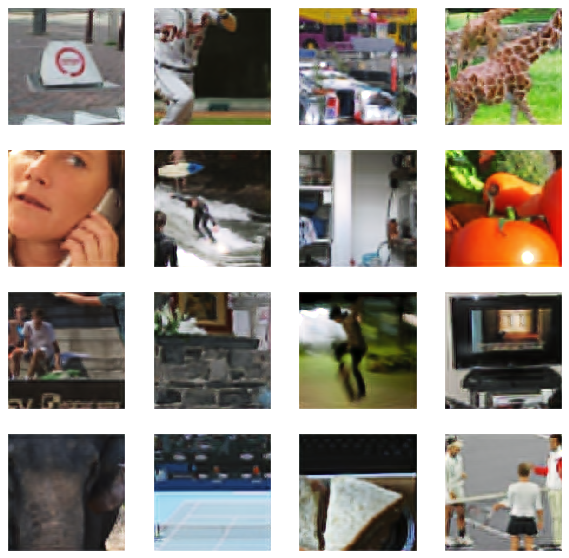

In [45]:
generated = autoencoder(batch.cuda()).detach().cpu()

show_batch(generated, figsize=(10,10))

### Decoded from random

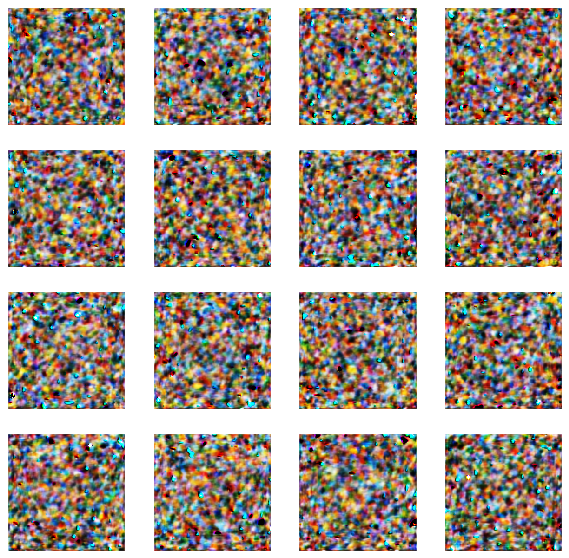

In [46]:
encoded_from_random = decoder(torch.randn((16,32,32,32)).cuda()).detach().cpu()

show_batch(encoded_from_random, figsize=(10,10))

### Shift encoded + decode

In [503]:
# diag_vec = torch.cat([torch.ones(16)*-1, torch.ones(16)])

# torch.diag(diag_vec)@torch.diag(torch.randn(32))

# # torch.tril(torch.ones(32,32))

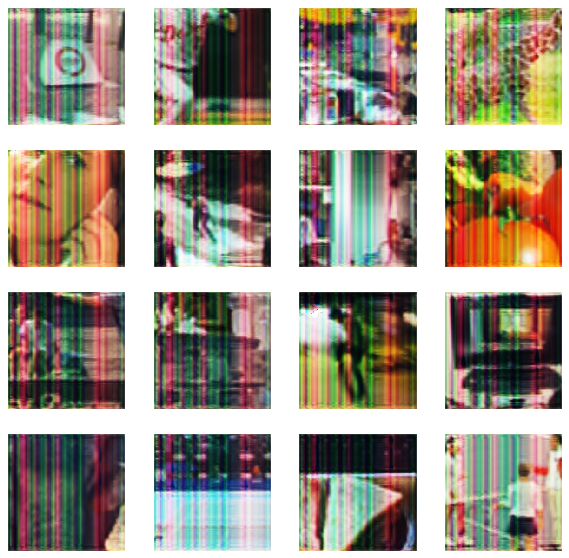

In [47]:
encoded = encoder(batch.cuda()).detach().cpu()
encoded = encoded.add_(torch.diag(torch.diag(torch.randn(32)/30)))
encoded = encoded.mul(1/encoded.max())

decoded = decoder(encoded.cuda()).detach().cpu()
show_batch(decoded, figsize=(10,10))

### Noise + encoded -> decode

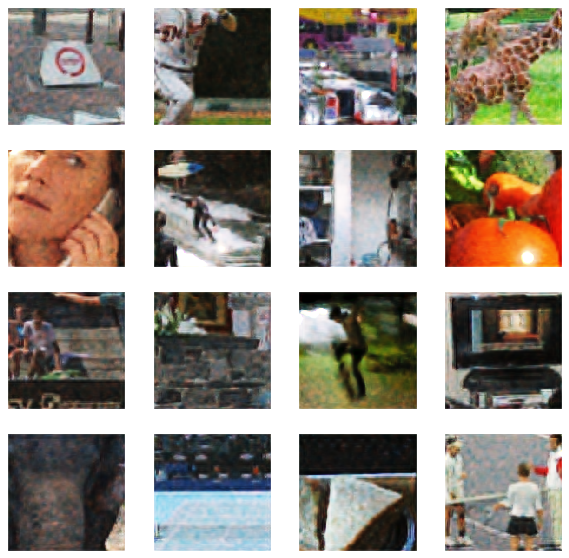

In [48]:
encoded = encoder(batch.cuda()).detach().cpu()
encoded = encoded.add_(torch.randn_like(encoded)/500)
encoded = encoded.mul(1/encoded.max())

decoded = decoder(encoded.cuda()).detach().cpu()
show_batch(decoded, figsize=(10,10))